# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [1]:
from copy import deepcopy
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from src.sim.scenario import Scenario
from src.sim.processing import SingleSimProcessor
from src.metrics import DEFAULT_METRICS
from src.logging import get_logger

logger = get_logger(__name__)

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

In [2]:
# Generate markets and prices
market_name = "wstETH"
scenario = Scenario("baseline", market_name)
scenario.prepare_for_run()
print(
    f"Running {scenario.num_steps} steps with frequency {scenario.pricepaths.config['freq']}."
)

[INFO][12:51:26][src.sim.scenario]-23638: Fetching sim_market from subgraph.
[INFO][12:51:30][src.sim.scenario]-23638: Market snapshot as 2024-01-05 12:04:11
[INFO][12:51:30][src.sim.scenario]-23638: Bands snapshot as 2024-01-04 19:09:35
[INFO][12:51:30][src.sim.scenario]-23638: Users snapshot as 2024-01-05 11:00:35
[INFO][12:51:33][src.sim.scenario]-23638: Using 62800 1Inch quotes from 2023-12-14 12:51:30.562968 to 2023-12-21 12:51:30.562968
[INFO][12:51:33][src.utils.poolgraph]-23638: Found 20 valid trading cycles of length 3.
[INFO][12:51:33][src.sim.scenario]-23638: Equilibrated prices with 2 arbitrages with total profit 4159
[INFO][12:51:33][src.sim.scenario]-23638: 3 users were loaded underwater.
[INFO][12:51:33][src.sim.scenario]-23638: Liquidating 0xe3c090f6f8ce7b69ba6957692af1ade1de745020: with debt 7630179987417032714146.
[INFO][12:51:33][src.sim.scenario]-23638: Liquidating 0x94f5319634aaf0bc16e677f8e139cdc61802abf3: with debt 164371161544797521276573.
[INFO][12:51:33][src.s

Running 168 steps with frequency 1h.


In [3]:
processor = SingleSimProcessor(scenario, DEFAULT_METRICS)
processor.initial_state

AttributeError: 'SingleSimProcessor' object has no attribute 'oracles'

Text(0.5, 1.0, 'wstETH Loan Distribution')

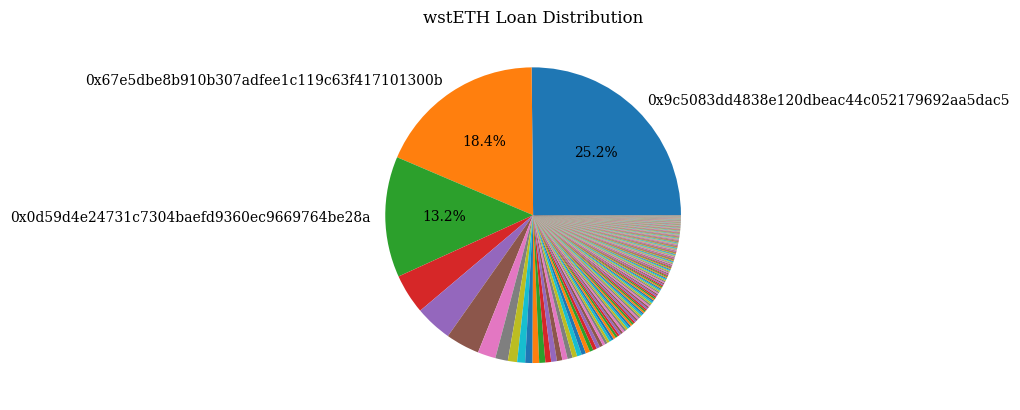

In [ ]:
def custom_autopct(pct):
    return "{:.1f}%".format(pct) if pct > 5 else ""


controller = scenario.controller
total_debt = 0
loans = {}
for user, loan in controller.loan.items():
    debt = loan.initial_debt / 1e18
    loans[user] = debt
    total_debt += debt

thresh = 0.05 * total_debt
loans = dict(sorted(loans.items(), key=lambda x: x[1], reverse=True))
labels = [a if loans[a] > thresh else "" for a in loans.keys()]
f, ax = plt.subplots()
pie = ax.pie(loans.values(), labels=labels, autopct=custom_autopct)
ax.set_title(f"{scenario.market_name} Loan Distribution")

### Run the Sim

In [ ]:
for sample in scenario.pricepaths:
    scenario.prepare_for_trades(sample)  # update prices/timestamps
    scenario.perform_actions(sample)  # arbitrage, liquidate, update
    scenario.price_oracle.freeze()
    processor.update(sample.timestamp, inplace=True)  # collect metrics
    scenario.price_oracle.unfreeze()

In [ ]:
results = processor.process()

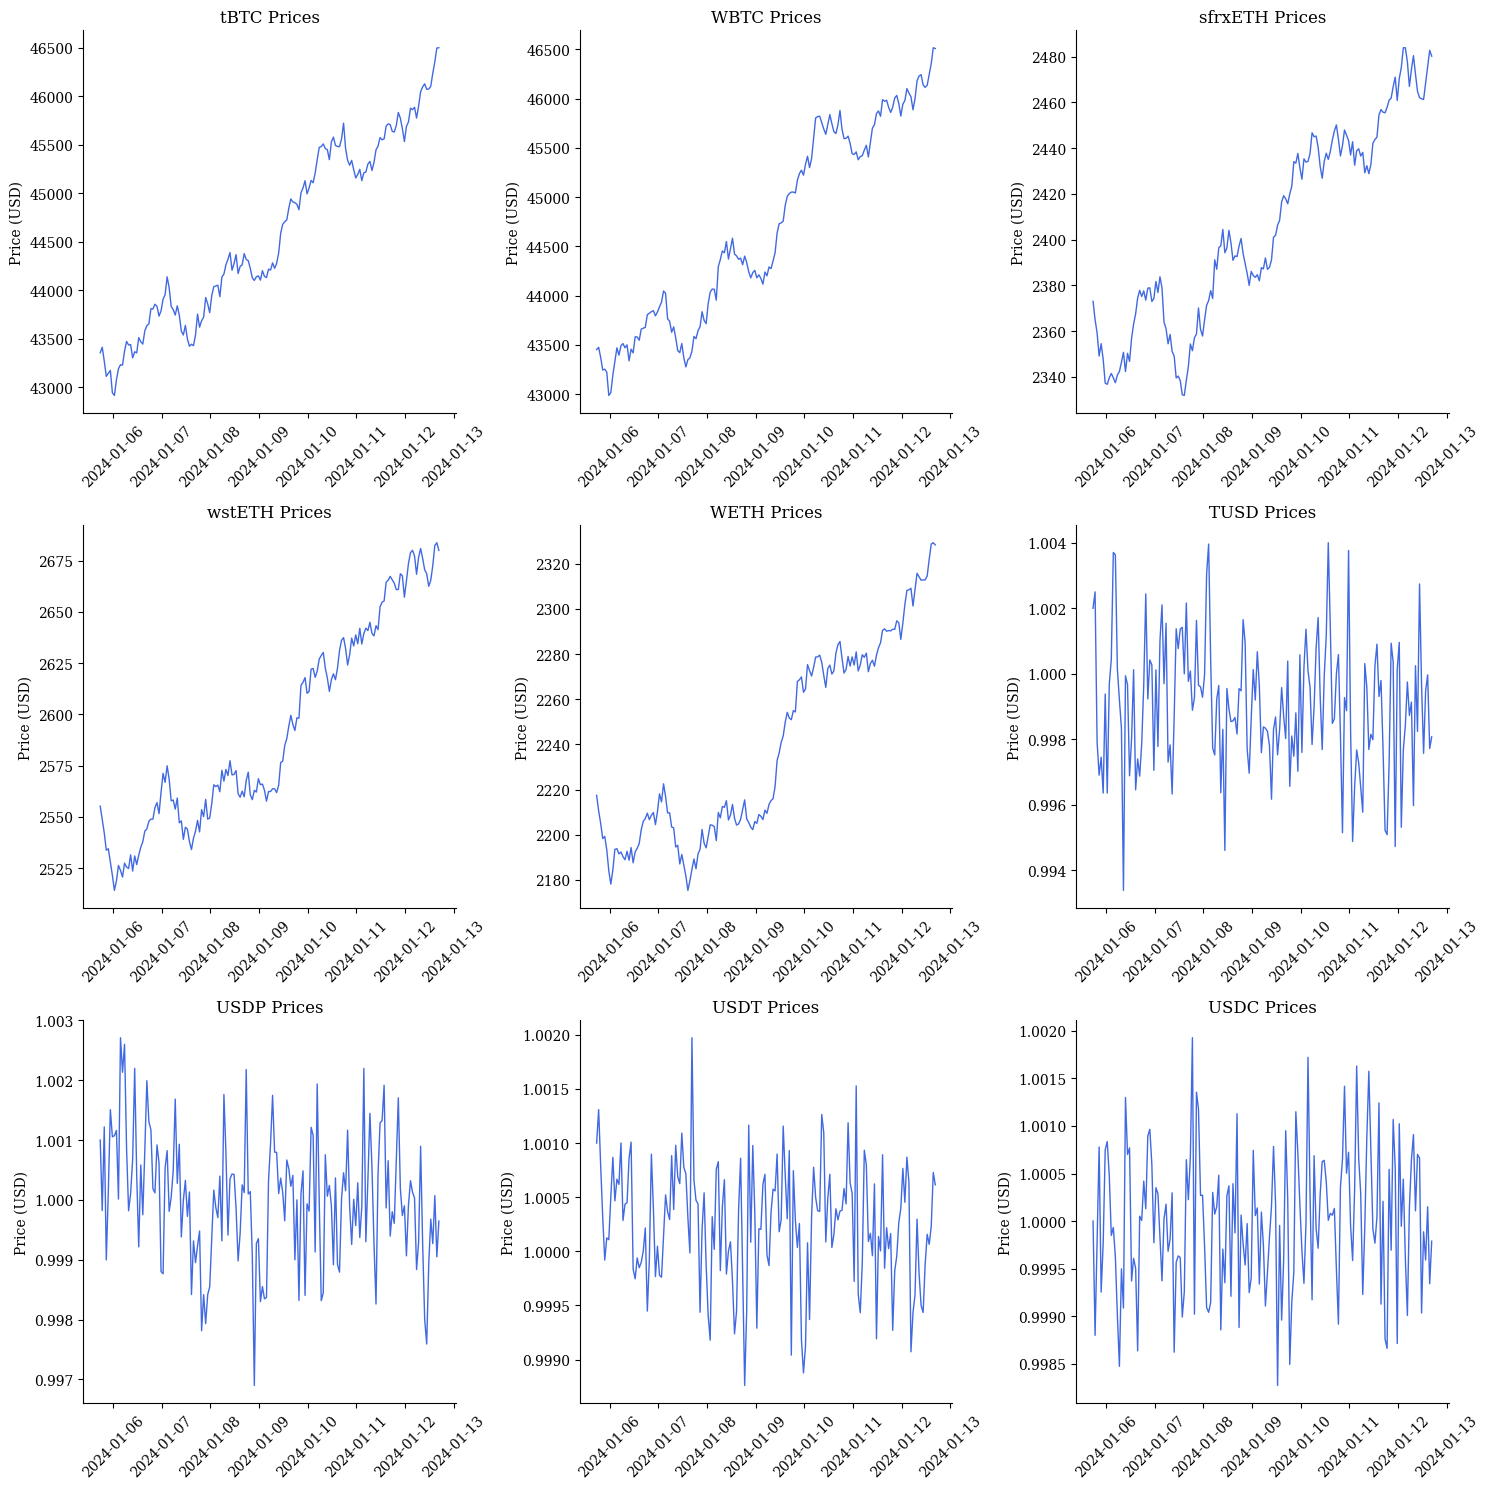

In [ ]:
results.plot_prices()

In [ ]:
df = results.df
# df.to_csv("../data/results.csv")
df.tail()

,arbitrageur_profit,arbitrageur_volume,arbitrageur_count,liquidator_profit,liquidator_volume,liquidator_count,keeper_profit,keeper_volume,keeper_count,borrower_profit,borrower_volume,borrower_count,liquidityprovider_profit,liquidityprovider_volume,liquidityprovider_count,aggregator_price,controller_wstETH_system_health,controller_wstETH_bad_debt,controller_wstETH_num_loans,controller_wstETH_total_debt,controller_wstETH_users_to_liquidate,llamma_wstETH_price,llamma_wstETH_oracle_price,llamma_wstETH_fees_x,llamma_wstETH_fees_y,llamma_wstETH_bal_x,llamma_wstETH_bal_y,pk_crvUSD/TUSD_debt,pk_crvUSD/TUSD_profit,pk_crvUSD/USDP_debt,pk_crvUSD/USDP_profit,pk_crvUSD/USDC_debt,pk_crvUSD/USDC_profit,pk_crvUSD/USDT_debt,pk_crvUSD/USDT_profit,stablecoin_total_supply,stableswap_crvUSD_TUSD_price,stableswap_crvUSD_TUSD_ma_price,stableswap_crvUSD_TUSD_lp_supply,stableswap_crvUSD_TUSD_virtual_price,stableswap_crvUSD_TUSD_TUSD_bal,stableswap_crvUSD_TUSD_crvUSD_bal,stableswap_crvUSD_USDP_price,stableswap_crvUSD_USDP_ma_price,stableswap_crvUSD_USDP_lp_supply,stableswap_crvUSD_USDP_virtual_price,stableswap_crvUSD_USDP_USDP_bal,stableswap_crvUSD_USDP_crvUSD_bal,stableswap_crvUSD_USDC_price,stableswap_crvUSD_USDC_ma_price,stableswap_crvUSD_USDC_lp_supply,stableswap_crvUSD_USDC_virtual_price,stableswap_crvUSD_USDC_USDC_bal,stableswap_crvUSD_USDC_crvUSD_bal,stableswap_crvUSD_USDT_price,stableswap_crvUSD_USDT_ma_price,stableswap_crvUSD_USDT_lp_supply,stableswap_crvUSD_USDT_virtual_price,stableswap_crvUSD_USDT_USDT_bal,stableswap_crvUSD_USDT_crvUSD_bal
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-12 12:38:01,173344.773160,0,466,3810.016971,0,2,543.041905,0,14,0.0,0,0,0.0,0,0,0.999775,0.557517,0.0,283,3.419468e+07,1,2656.698098,2665.599697,3003,0,103394.749157,22487.045500,0.0,2240.612812,0.0,0.0,1.290837e+06,0.0,0.0,0.0,4.481064e+08,1.001303,1.000742,4.277065e+06,1.000776,2.735255e+06,1.545485e+06,1.000017,1.000027,2.685539e+06,1.000458,1.349046e+06,1.337723e+06,1.000025,1.000025,3.211428e+07,1.000279,0.000016,1.596284e+07,0.999380,0.999345,2.809336e+07,1.000295,0.000012,1.613941e+07
2024-01-12 13:38:01,173385.427132,0,468,3810.016971,0,2,543.041905,0,14,0.0,0,0,0.0,0,0,0.999802,0.562340,0.0,283,3.419509e+07,1,2679.704359,2673.305148,3003,0,103394.749157,22487.045500,0.0,2240.612812,0.0,0.0,1.290837e+06,0.0,0.0,0.0,4.482576e+08,1.000904,1.000982,4.277065e+06,1.000777,2.583927e+06,1.696655e+06,1.000372,1.000367,2.685539e+06,1.000460,1.466522e+06,1.220276e+06,1.000033,1.000033,3.211428e+07,1.000279,0.000016,1.592911e+07,0.999380,0.999379,2.809336e+07,1.000295,0.000012,1.613941e+07
2024-01-12 14:38:01,173430.078716,0,471,3810.016971,0,2,543.041905,0,14,0.0,0,0,0.0,0,0,0.999797,0.567853,0.0,283,3.419551e+07,1,2701.081442,2682.115061,3003,0,99230.637924,22488.594983,0.0,2240.612812,0.0,0.0,1.290837e+06,0.0,0.0,0.0,4.486806e+08,1.000740,1.000753,4.277065e+06,1.000778,2.513227e+06,1.767301e+06,1.000372,1.000372,2.685539e+06,1.000460,1.466522e+06,1.220276e+06,0.999945,0.999947,3.211428e+07,1.000280,0.000016,1.628148e+07,0.999512,0.999492,2.809336e+07,1.000296,0.000012,1.572054e+07
2024-01-12 15:38:01,173725.787332,0,474,3810.016971,0,2,543.041905,0,14,0.0,0,0,0.0,0,0,0.999842,0.569002,0.0,283,3.419593e+07,1,2704.645932,2683.976165,3003,0,97613.582607,22489.196251,0.0,2240.612812,0.0,0.0,1.290837e+06,0.0,0.0,0.0,4.497692e+08,1.001007,1.001003,4.277065e+06,1.000780,2.626054e+06,1.654577e+06,1.000372,1.000372,2.685539e+06,1.000460,1.466522e+06,1.220276e+06,1.000188,1.000185,3.211428e+07,1.000281,0.000017,1.530880e+07,0.999154,0.999198,2.809336e+07,1.000298,0.000011,1.680751e+07
2024-01-12 16:38:01,173726.910480,0,475,3810.016971,0,2,543.041905,0,14,0.0,0,0,0.0,0,0,0.999829,0.566402,0.0,283,3.419635e+07,1,2692.223313,2679.868644,3003,0,97613.582607,22489.196251,0.0,2240.612812,0.0,0.0,1.290837e+06,0.0,0.0,0.0,4.497892e+08,1.001058,1.001057,4.277065e+06,1.000780,2.646011e+06,1.634642e+06,1.000310,1.000310,2.685539e+06,1.000461,1.44658

In [ ]:
results.metric_map

{'AgentMetrics': 0,
 'AggregatorMetrics': 1,
 'ControllerMetrics': 2,
 'LLAMMAMetrics': 3,
 'PegKeeperMetrics': 4,
 'StablecoinMetrics': 5,
 'StableSwapMetrics': 6}

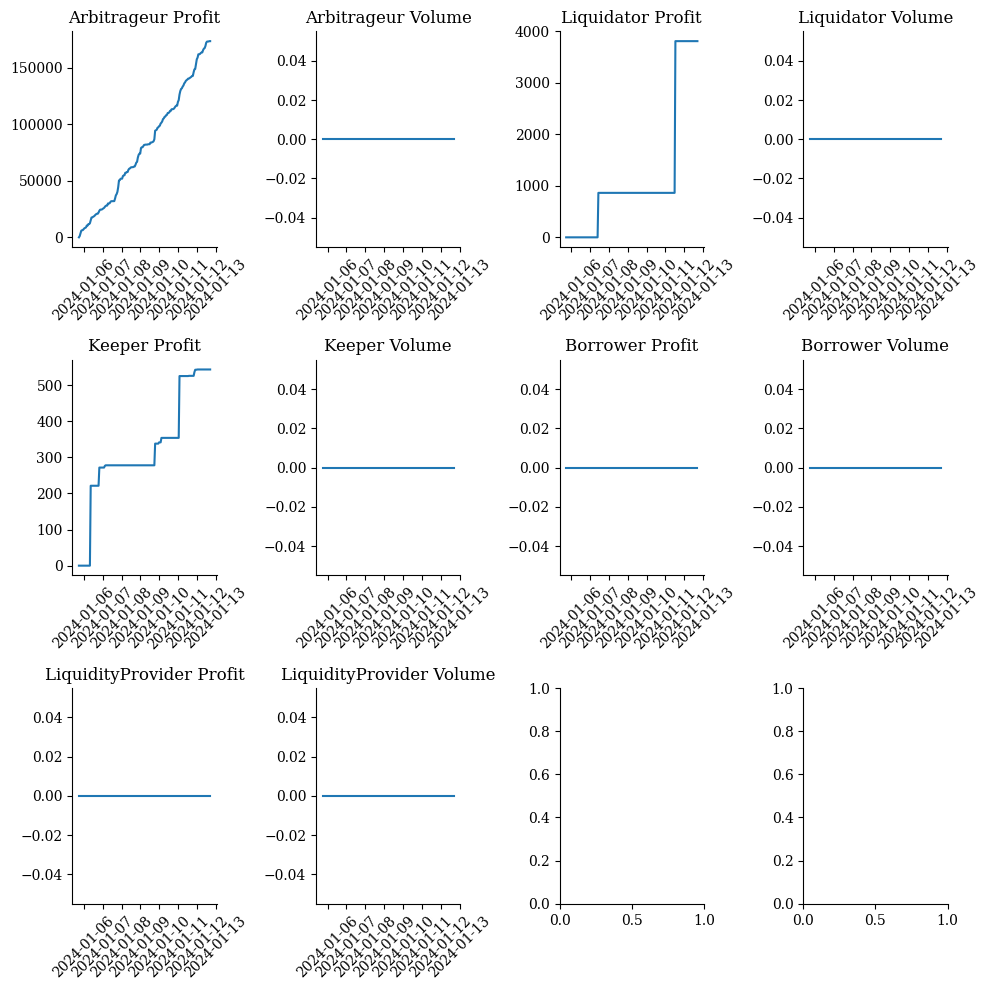

array([[<Axes: title={'center': 'Arbitrageur Profit'}>,
        <Axes: title={'center': 'Arbitrageur Volume'}>,
        <Axes: title={'center': 'Liquidator Profit'}>,
        <Axes: title={'center': 'Liquidator Volume'}>],
       [<Axes: title={'center': 'Keeper Profit'}>,
        <Axes: title={'center': 'Keeper Volume'}>,
        <Axes: title={'center': 'Borrower Profit'}>,
        <Axes: title={'center': 'Borrower Volume'}>],
       [<Axes: title={'center': 'LiquidityProvider Profit'}>,
        <Axes: title={'center': 'LiquidityProvider Volume'}>, <Axes: >,
        <Axes: >]], dtype=object)

In [ ]:
results.plot_metric(0, show=True)

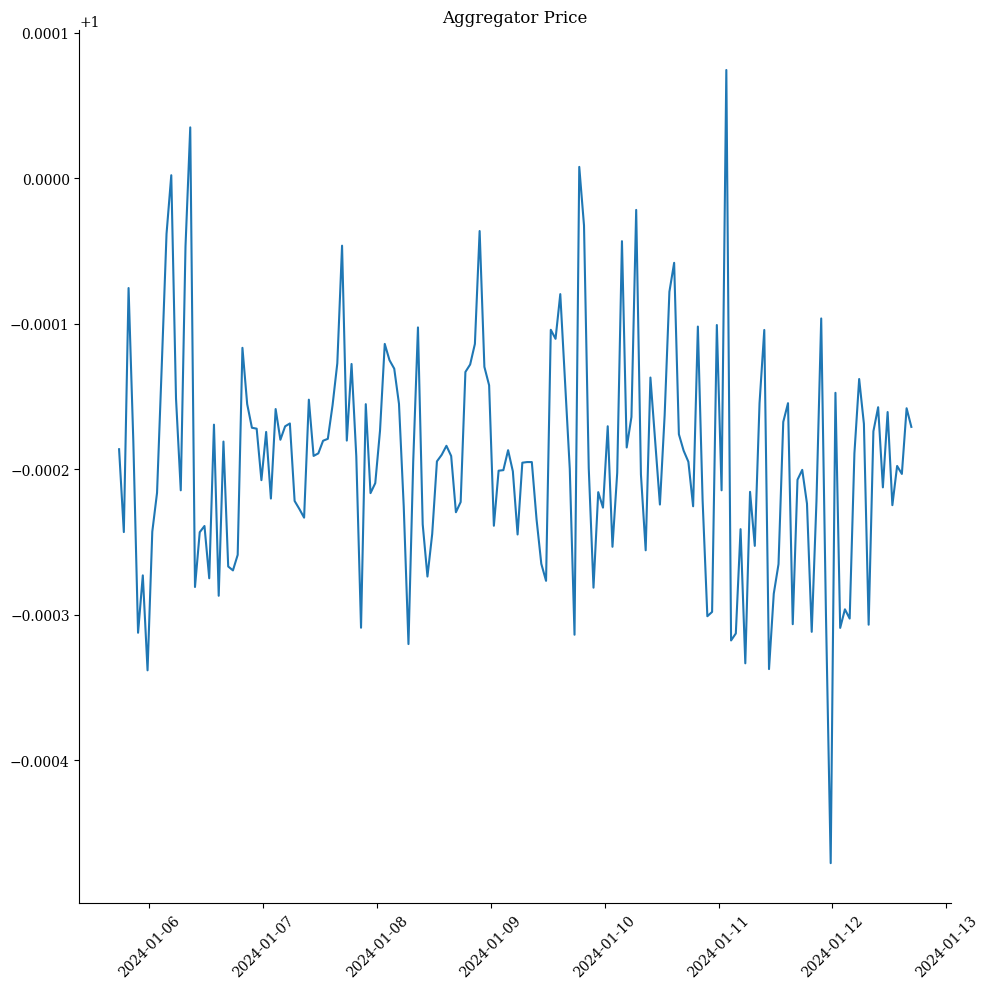

<Axes: title={'center': 'Aggregator Price'}>

In [ ]:
results.plot_metric(1, show=True)

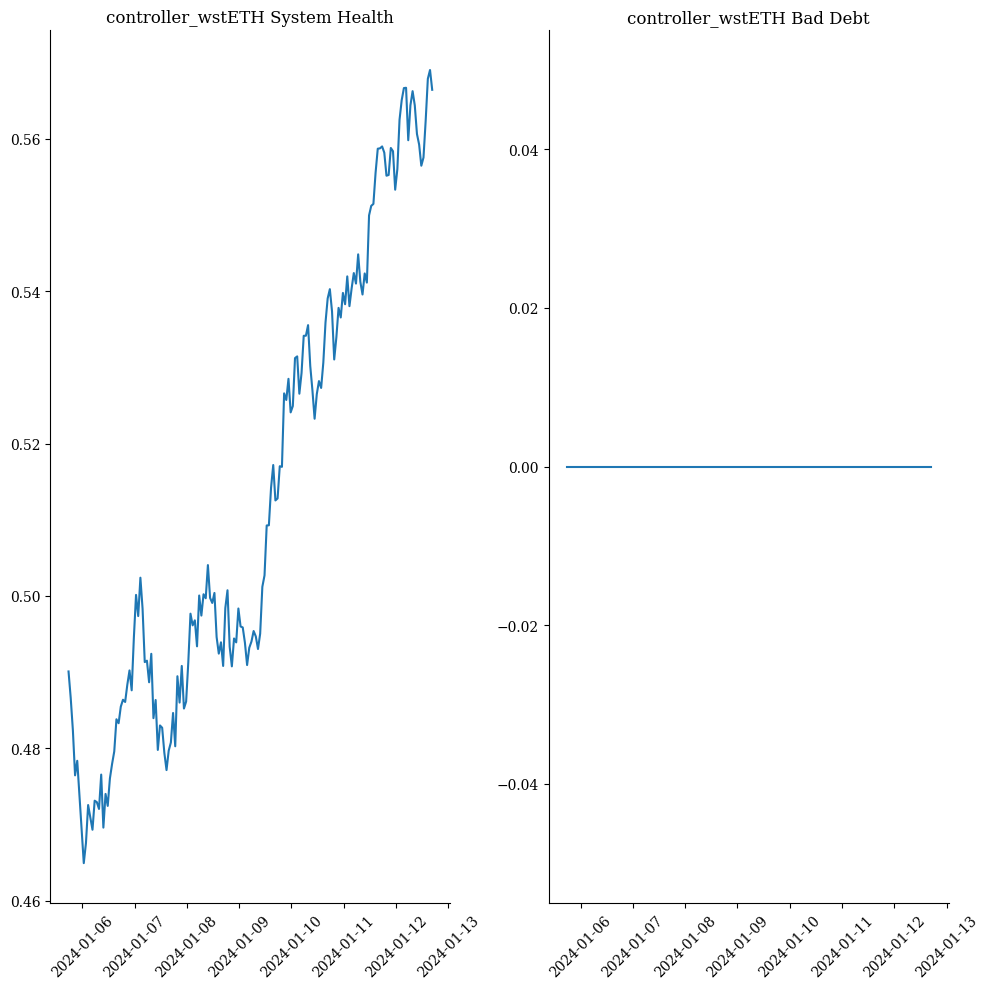

array([<Axes: title={'center': 'controller_wstETH System Health'}>,
       <Axes: title={'center': 'controller_wstETH Bad Debt'}>],
      dtype=object)

In [ ]:
results.plot_metric(2, show=True)

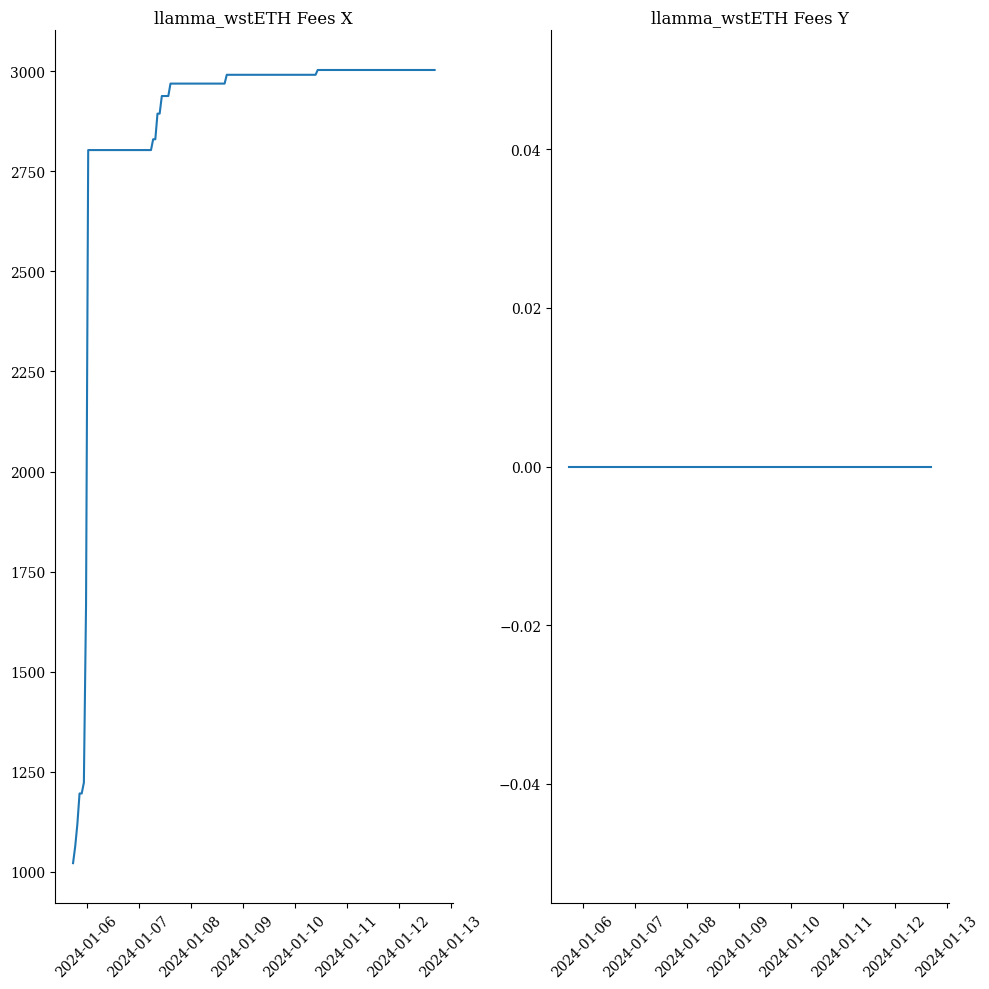

array([<Axes: title={'center': 'llamma_wstETH Fees X'}>,
       <Axes: title={'center': 'llamma_wstETH Fees Y'}>], dtype=object)

In [ ]:
results.plot_metric(3, show=True)  # seems broken from crvusdsim

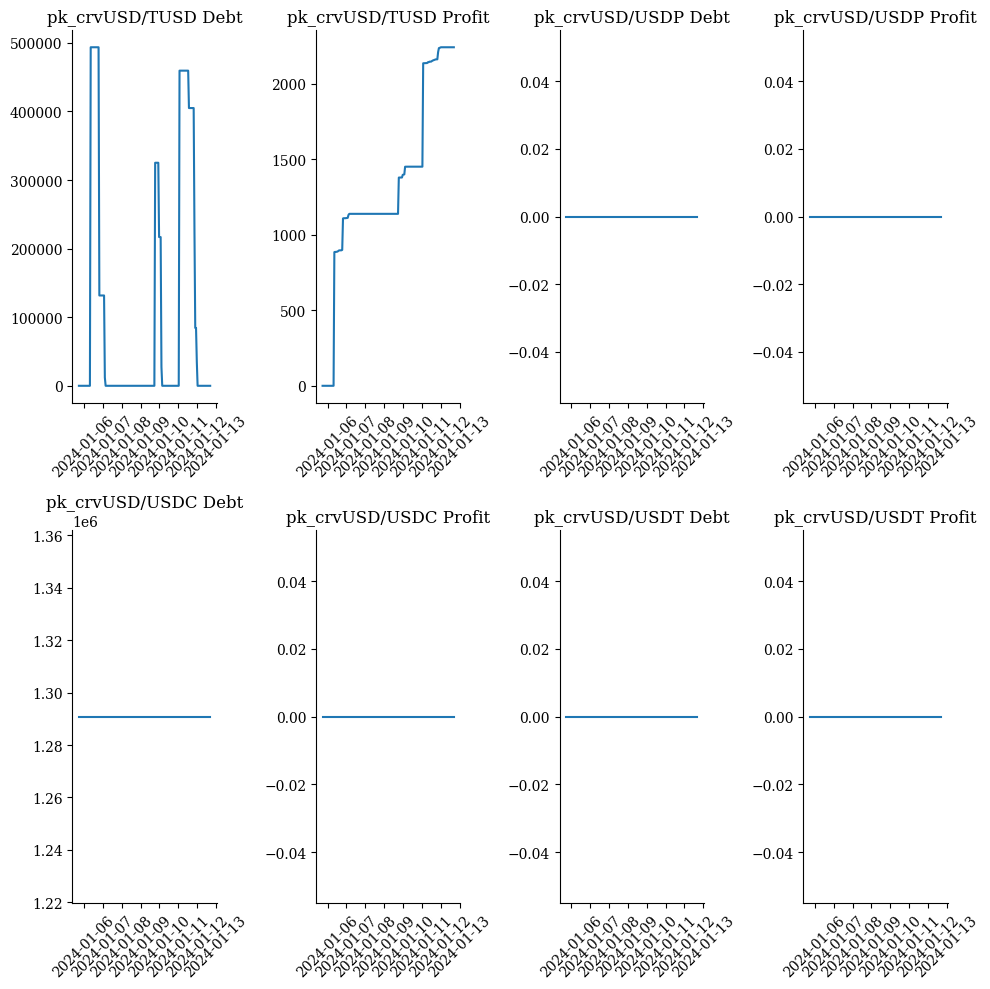

array([[<Axes: title={'center': 'pk_crvUSD/TUSD Debt'}>,
        <Axes: title={'center': 'pk_crvUSD/TUSD Profit'}>,
        <Axes: title={'center': 'pk_crvUSD/USDP Debt'}>,
        <Axes: title={'center': 'pk_crvUSD/USDP Profit'}>],
       [<Axes: title={'center': 'pk_crvUSD/USDC Debt'}>,
        <Axes: title={'center': 'pk_crvUSD/USDC Profit'}>,
        <Axes: title={'center': 'pk_crvUSD/USDT Debt'}>,
        <Axes: title={'center': 'pk_crvUSD/USDT Profit'}>]], dtype=object)

In [ ]:
results.plot_metric(4, show=True)

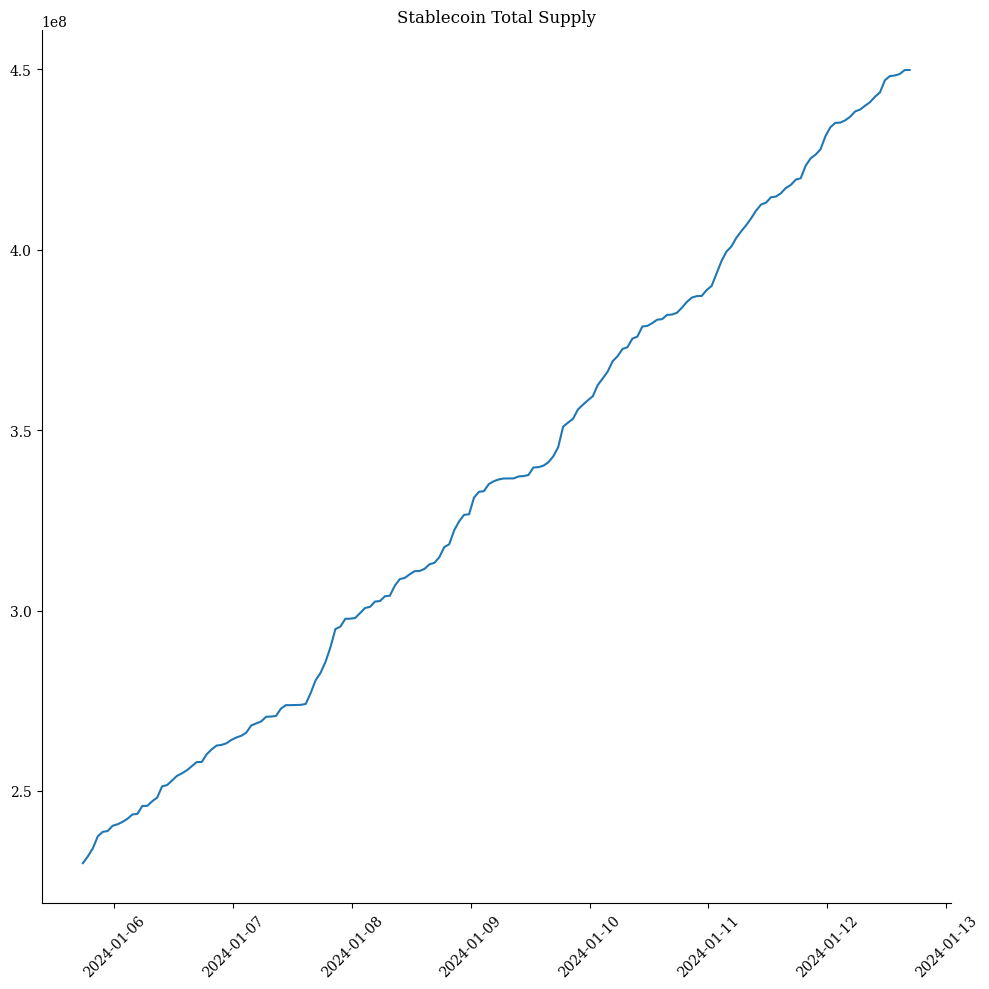

<Axes: title={'center': 'Stablecoin Total Supply'}>

In [ ]:
results.plot_metric(5, show=True)

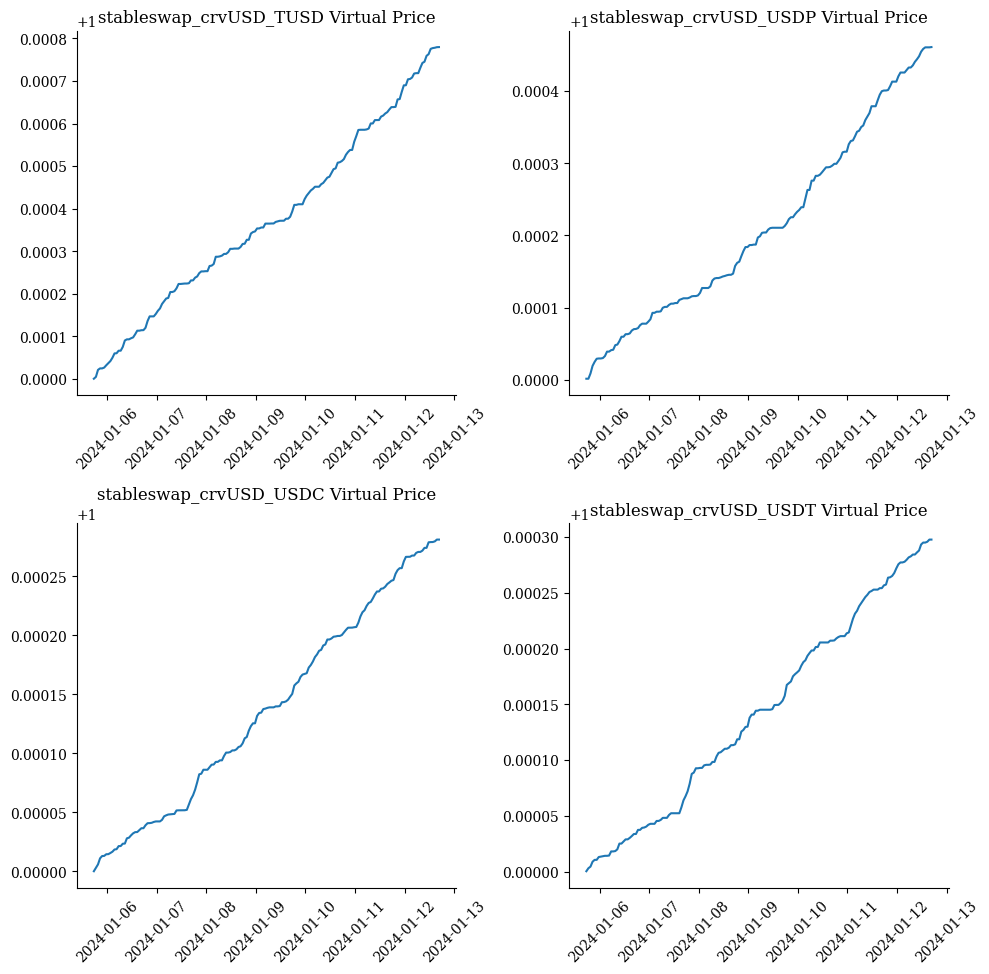

array([[<Axes: title={'center': 'stableswap_crvUSD_TUSD Virtual Price'}>,
        <Axes: title={'center': 'stableswap_crvUSD_USDP Virtual Price'}>],
       [<Axes: title={'center': 'stableswap_crvUSD_USDC Virtual Price'}>,
        <Axes: title={'center': 'stableswap_crvUSD_USDT Virtual Price'}>]],
      dtype=object)

In [ ]:
results.plot_metric(6, show=True)

In [ ]:
summary = results.summary.T
summary.columns = ["value"]
summary

,value
arbitrageur_profit_max,1.766558e+05
arbitrageur_volume_max,0.000000e+00
liquidator_profit_max,0.000000e+00
liquidator_volume_max,0.000000e+00
keeper_profit_max,6.898248e+02
keeper_volume_max,0.000000e+00
borrower_profit_max,0.000000e+00
borrower_volume_max,0.000000e+00
liquidityprovider_profit_max,0.000000e+00
liquidityprovider_volume_max,0.000000e+00


In [ ]:
df.columns

Index(['arbitrageur_profit', 'arbitrageur_volume', 'arbitrageur_count',
       'liquidator_profit', 'liquidator_volume', 'liquidator_count',
       'keeper_profit', 'keeper_volume', 'keeper_count', 'borrower_profit',
       'borrower_volume', 'borrower_count', 'liquidityprovider_profit',
       'liquidityprovider_volume', 'liquidityprovider_count',
       'aggregator_price', 'controller_wstETH_system_health',
       'controller_wstETH_bad_debt', 'controller_wstETH_num_loans',
       'controller_wstETH_total_debt', 'controller_wstETH_users_to_liquidate',
       'llamma_wstETH_price', 'llamma_wstETH_oracle_price',
       'llamma_wstETH_fees_x', 'llamma_wstETH_fees_y', 'llamma_wstETH_bal_x',
       'llamma_wstETH_bal_y', 'pk_crvUSD/TUSD_debt', 'pk_crvUSD/TUSD_profit',
       'pk_crvUSD/USDP_debt', 'pk_crvUSD/USDP_profit', 'pk_crvUSD/USDC_debt',
       'pk_crvUSD/USDC_profit', 'pk_crvUSD/USDT_debt', 'pk_crvUSD/USDT_profit',
       'stablecoin_total_supply', 'stableswap_crvUSD_TUSD_price',


<Axes: xlabel='timestamp'>

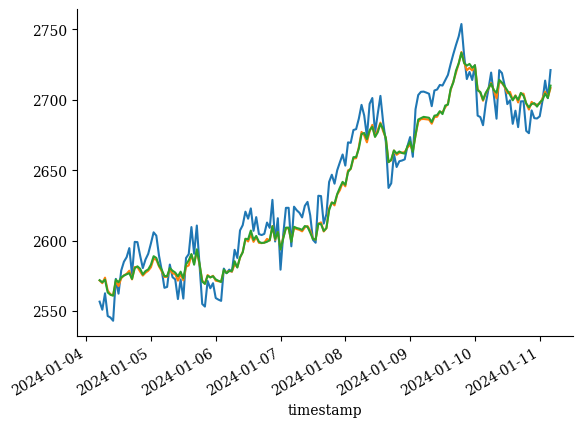

In [ ]:
df["llamma_wstETH_price"].plot()
df["llamma_wstETH_oracle_price"].plot()
results.pricepaths.prices["0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0"].plot()

<Axes: xlabel='timestamp'>

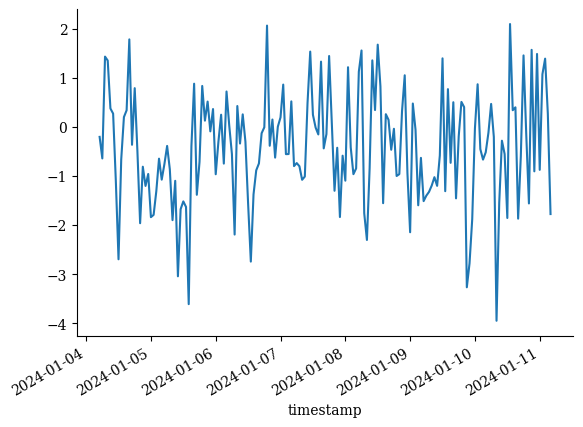

In [ ]:
(
    df["llamma_wstETH_oracle_price"]
    - results.pricepaths.prices["0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0"]
).plot()